#  UTAG Input & Output Summary

##  Input to UTAG
- **AnnData Object (`minimal_adata`)** with:
  - `X`: Numeric feature matrix (float64).
  - `obs`: Includes at least:
    - `roi`: Slide identifier.
  - `obsm['spatial']`: 2D numpy array of Y and X coordinates.
  - `var`: Feature metadata.

##  Output from UTAG
- `adata.obs`: Adds a new column for cluster labels, e.g.:
  - `UTAG Label_leiden_0.2`
- Same `AnnData` structure but with cluster annotations.


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from utag import utag

# Read Data and dealing with spatial coordinate

In [ ]:
# --- 1 ---
adata = sc.read_h5ad('/home/utag/annotation_xenium_tacco.h5ad')

# --- 2 ---
adata.obs['x'] = adata.obs['x_centroid']
adata.obs['y'] = adata.obs['y_centroid']
adata.obsm['spatial'] = adata.obs[['y', 'x']].to_numpy()

# --- 3 ---
np.random.seed(42)
random_indices = np.random.choice(adata.n_obs, size=10000, replace=False)
adata = adata[random_indices].copy()

# Prepare for minimal AnnData

In [3]:
# --- 4 ---
if 'roi' not in adata.obs:
    adata.obs['roi'] = 'ROI1'

X = adata.X
obs = adata.obs[['roi']].copy()
var = pd.DataFrame(index=[f'feature_{i}' for i in range(X.shape[1])])

minimal_adata = anndata.AnnData(X=X, obs=obs, var=var)
minimal_adata.obsm['spatial'] = adata.obsm['spatial']

# Using UTAG

In [4]:
# --- 5 ---
utag_results = utag(
    minimal_adata,
    slide_key="roi",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method='leiden',
    resolutions=[0.2]
)


Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.2...


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


# Visualization

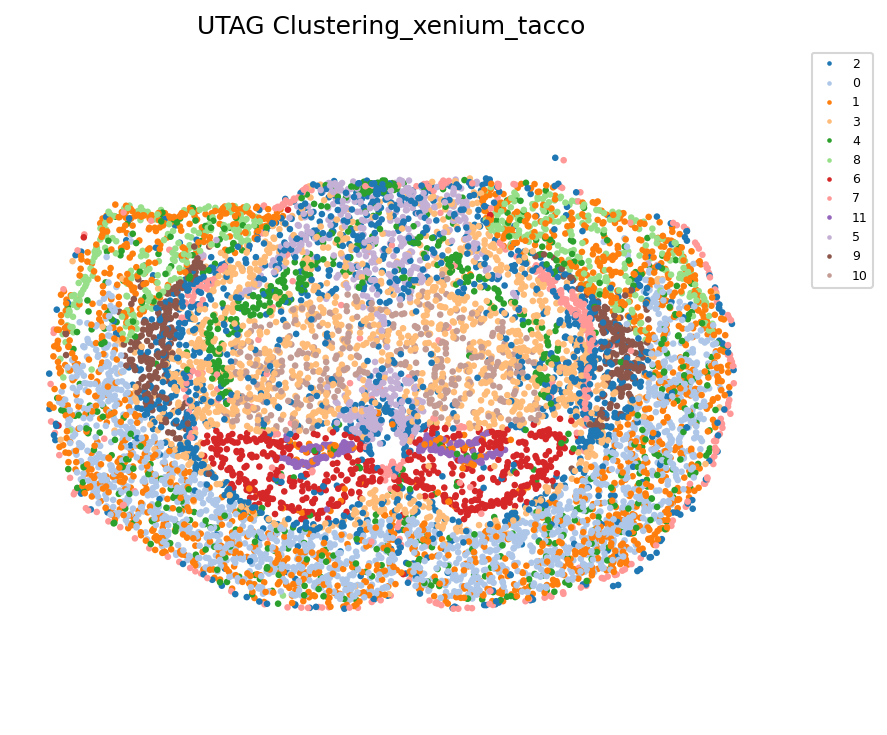

In [5]:
# --- 6 ---
spatial_coords = pd.DataFrame(minimal_adata.obsm['spatial'], columns=['y', 'x'])
utag_labels = utag_results.obs['UTAG Label_leiden_0.2'].astype(str).to_numpy()

plt.figure(figsize=(6, 5), dpi=150)
sns.scatterplot(
    x=spatial_coords['x'],
    y=-spatial_coords['y'],  # 反转y坐标
    hue=utag_labels,
    palette='tab20',
    s=10,
    linewidth=0
)
plt.title("UTAG Clustering_xenium_tacco")
plt.axis('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, markerscale=0.7, frameon=True)
plt.tight_layout()
plt.show()

# Calculate ARI

In [ ]:
# --- 7 ---
true_domains = adata.obs['cleaned_cluster'].to_numpy()
predicted_domains = utag_results.obs['UTAG Label_leiden_0.2'].to_numpy()

valid_mask = ~pd.isna(true_domains)
true_domains_clean = true_domains[valid_mask]
predicted_domains_clean = predicted_domains[valid_mask]

ari_score = adjusted_rand_score(true_domains_clean, predicted_domains_clean)
print(f"\nAdjusted Rand Index (ARI) between UTAG clustering and true domains: {ari_score:.4f}")